In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

/Users/anwesh/opt/anaconda3/envs/tf/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
ch_dir = "../../Smart Attack Algorithm/data/Car Hacking Dataset"
normal_data = os.path.join(ch_dir, 'benign_data.csv')
dos_data_path = os.path.join(ch_dir, 'DoS_dataset.csv')

In [3]:
normal_data = pd.read_csv(normal_data)
normal_data.head()

,Timestamp,ID,DLC,Payload,label
0,1.479121e+09,0350,8,052884666d0000a2,0
1,1.479121e+09,02c0,8,1400000000000000,0
2,1.479121e+09,0430,8,0000000000000000,0
3,1.479121e+09,04b1,8,0000000000000000,0
4,1.479121e+09,01f1,8,0000000000000000,0


In [4]:
def transform_data(data):

    data['ID'] = data['ID'].apply(hex_to_dec)
    data['Payload'] = data['Payload'].apply(hex_to_dec)
    data['Timestamp'] = pd.to_datetime(data['Timestamp'], unit='s')
    data['Anomaly'] = 0  # New column to store anomaly labels

    return data

hex_to_dec = lambda x: int(x, 16)

normal_data = transform_data(normal_data)

In [5]:
def shift_columns(df):
    
    for dlc in [2,5,6]:

        df.loc[df['DLC'] == dlc, df.columns[3:]] = df.loc[df['DLC'] == dlc, df.columns[3:]].shift(periods=8-dlc, axis='columns', fill_value='00')

    return df
    

def read_ch_data(data_path):
    
    columns = ['Timestamp','ID', 'DLC', 'data0', 'data1', 'data2', 'data3', 'data4', 
           'data5', 'data6', 'data7', 'label']
    
    data = pd.read_csv(data_path, names = columns)

    data = shift_columns(data)
    
    ##Replacing all NaNs with '00' 
    data = data.replace(np.NaN, '00')
    
    ##Joining all data columns to put all data in one column
    data_cols = ['data0', 'data1', 'data2', 'data3', 'data4', 'data5', 'data6', 'data7']
    
    ##The data column is in hexadecimal
    data['Payload'] = data[data_cols].apply(''.join, axis=1)
    data.drop(columns = data_cols, inplace = True, axis = 1)
        
    data = data.assign(IAT=data['Timestamp'].diff().fillna(0))
    data = data[['Timestamp', 'ID','DLC','Payload', 'label']]
    data['label'].replace({'R' : 0, 'T' : 1}, inplace = True)
    
    return data




In [6]:
normal_data.head()

,Timestamp,ID,DLC,Payload,label,Anomaly
0,2016-11-14 11:03:54.850202084,848,8,371692544708313250,0,0
1,2016-11-14 11:03:54.850423098,704,8,1441151880758558720,0,0
2,2016-11-14 11:03:54.850976944,1072,8,0,0,0
3,2016-11-14 11:03:54.851214886,1201,8,0,0,0
4,2016-11-14 11:03:54.851463079,497,8,0,0,0


In [7]:
print(f"Data columns: {(normal_data.columns)}")

Data columns: Index(['Timestamp', 'ID', 'DLC', 'Payload', 'label', 'Anomaly'], dtype='object')


In [8]:
def split_into_windows(df, window_size):
    start_time = df['Timestamp'].min()
    end_time = df['Timestamp'].max()

    windows = []
    current_time = start_time

    while current_time <= end_time:
        window = df[(df['Timestamp'] >= current_time) &
                    (df['Timestamp'] < current_time + pd.to_timedelta(window_size, unit='s'))].copy()

        if not window.empty:
            window['Periodicity'] = window.groupby('ID')['Timestamp'].diff().dt.total_seconds()
            window['Periodicity'] = window['Periodicity'].fillna(0)
            windows.append(window)

        current_time += pd.to_timedelta(window_size, unit='s')

    return windows

In [9]:
def arima_anomaly_detection(window, order=(0, 0, 0), mse_threshold=0.01):
    anomalies = []

    for can_id in window['ID'].unique():
        id_data = window[window['ID'] == can_id]['Periodicity'].values
        indices = window[window['ID'] == can_id].index  # Keep track of original row indices

        if len(id_data) >= 3:
            try:
                model = ARIMA(id_data, order=order)
                model_fit = model.fit()
                predictions = model_fit.predict()

                mse = mean_squared_error(id_data, predictions)

                if mse > mse_threshold:
                    anomalies.extend(indices.tolist())

            except Exception as e:
                print(f"ARIMA failed for ID {can_id}: {e}")
                continue

    return anomalies

In [10]:
windows = split_into_windows(normal_data, window_size=1)

In [ ]:
def evaluate(true_labels, predictions):

    TP = np.sum((predictions == 1) & (true_labels == 1))
    TN = np.sum((predictions == 0) & (true_labels == 0))
    FP = np.sum((predictions == 1) & (true_labels == 0))
    FN = np.sum((predictions == 0) & (true_labels == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    TPR = recall  # True Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate

    #Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"TPR: {TPR:.4f}")
    print(f"FPR: {FPR:.4f}")
    print(f"TNR: {TNR:.4f}")
    print(f"FNR: {FNR:.4f}")

    if len(set(list(true_labels))) == 2:

        print("")
        print(classification_report(true_labels, predictions, target_names=['Benign', 'Attack']))

        ##Plot confusion matrix with seaborn
        cm = confusion_matrix(true_labels, predictions)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
        cm_display.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()
    else:
        pass



# === Modified ARIMA MSE collector ===
def collect_mse_per_window(windows, order=(0, 0, 0)):
    """
    Computes MSE for each ID in each window.
    Returns a dataframe: Timestamp, ID, MSE
    """
    mse_records = []

    for window in tqdm(windows, desc="Computing MSEs"):
        window_start_time = window['Timestamp'].min()
        for can_id in window['ID'].unique():
            id_data = window[window['ID'] == can_id]['Periodicity'].values

            if len(id_data) >= 3:
                try:
                    model = ARIMA(id_data, order=order)
                    model_fit = model.fit()
                    predictions = model_fit.predict()

                    mse = mean_squared_error(id_data, predictions)

                    mse_records.append({
                        'Timestamp': window_start_time,
                        'ID': can_id,
                        'MSE': mse
                    })
                except Exception as e:
                    print(f"ARIMA failed for ID {can_id}: {e}")
                    continue
    return pd.DataFrame(mse_records)


# === Now applying multiple thresholds ===
def apply_thresholds_and_evaluate(mse_df, dos_data, thresholds):
    for threshold in thresholds:
        print(f"\n=== THRESHOLD {threshold} ===")

        # Initialize Anomaly column
        dos_data['Anomaly'] = 0
        print("Initi anomaly column")


        # Find anomalies based on threshold 
        anomalies_df = mse_df[mse_df['MSE'] > threshold]

        print("Iterating through anomalies_df")
        for _, row in anomalies_df.iterrows():
            mask = (dos_data['ID'] == row['ID']) & (dos_data['Timestamp'] >= row['Timestamp'])
            dos_data.loc[mask, 'Anomaly'] = 1

        y_true = dos_data['label']
        y_preds = dos_data['Anomaly']

        print("Starting Evaluation")
        evaluate(y_true, y_preds)


In [12]:
dos_data = read_ch_data(dos_data_path)
dos_data = transform_data(dos_data)

In [13]:
dos_windows = split_into_windows(dos_data, window_size=1)
mse_df = collect_mse_per_window(dos_windows, order=(0, 0, 0))

Computing MSEs: 100%|██████████| 2811/2811 [19:32<00:00,  2.40it/s] 


In [14]:
thresholds = np.linspace(1e-07, 1e-5, num=30)
print(thresholds)

[1.00000000e-07 4.41379310e-07 7.82758621e-07 1.12413793e-06
 1.46551724e-06 1.80689655e-06 2.14827586e-06 2.48965517e-06
 2.83103448e-06 3.17241379e-06 3.51379310e-06 3.85517241e-06
 4.19655172e-06 4.53793103e-06 4.87931034e-06 5.22068966e-06
 5.56206897e-06 5.90344828e-06 6.24482759e-06 6.58620690e-06
 6.92758621e-06 7.26896552e-06 7.61034483e-06 7.95172414e-06
 8.29310345e-06 8.63448276e-06 8.97586207e-06 9.31724138e-06
 9.65862069e-06 1.00000000e-05]



=== THRESHOLD 1e-07 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



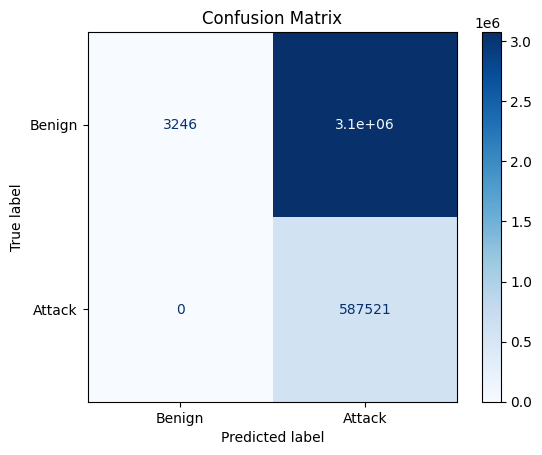


=== THRESHOLD 4.413793103448276e-07 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



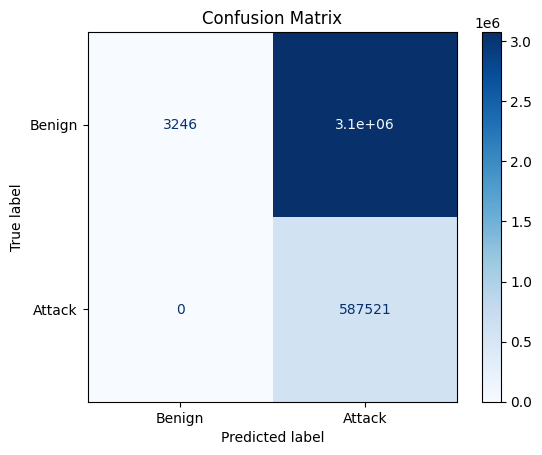


=== THRESHOLD 7.827586206896552e-07 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



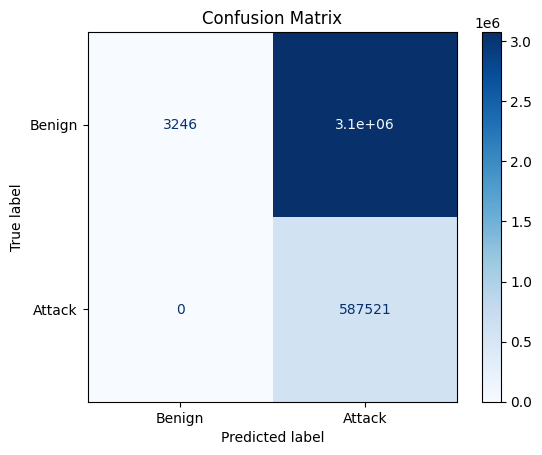


=== THRESHOLD 1.1241379310344827e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



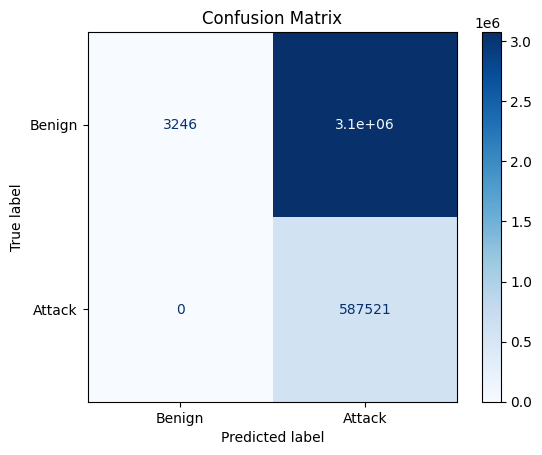


=== THRESHOLD 1.4655172413793102e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



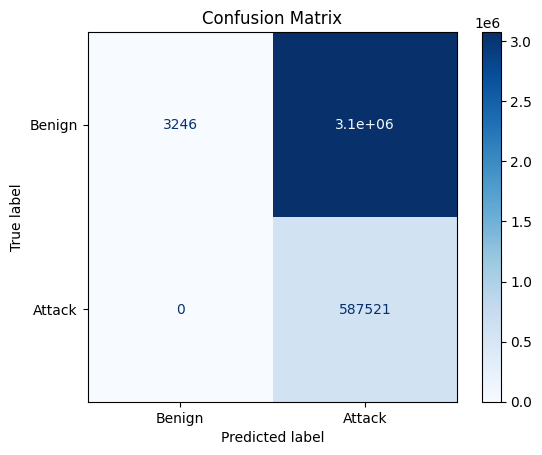


=== THRESHOLD 1.8068965517241377e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



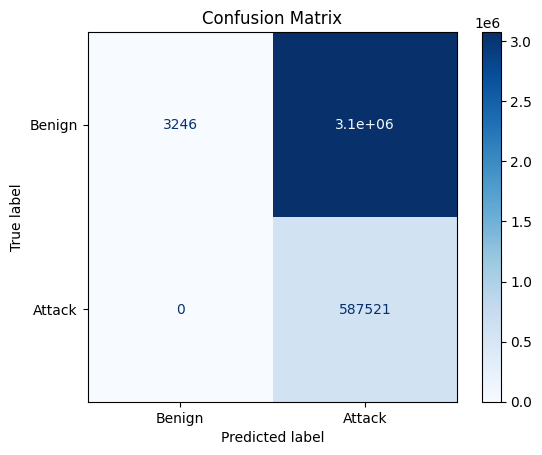


=== THRESHOLD 2.1482758620689656e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



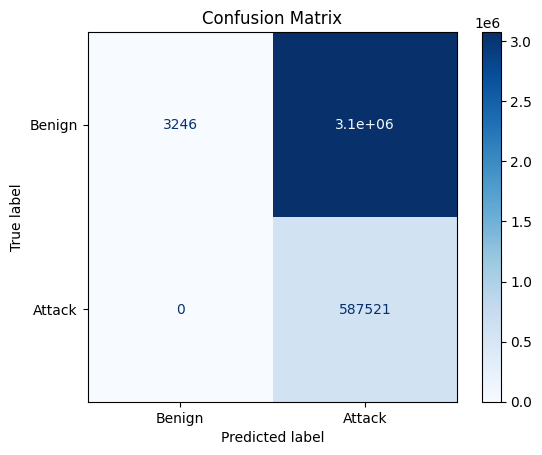


=== THRESHOLD 2.489655172413793e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



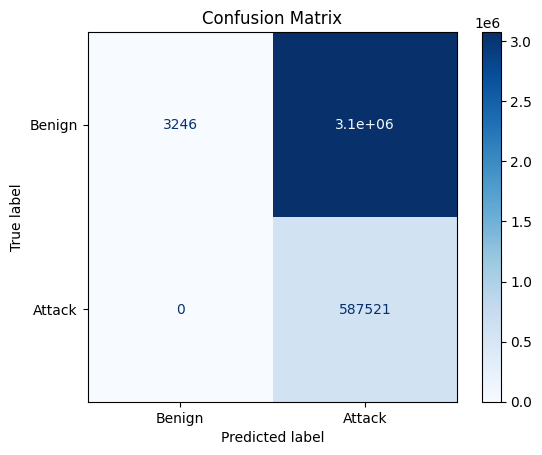


=== THRESHOLD 2.8310344827586205e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



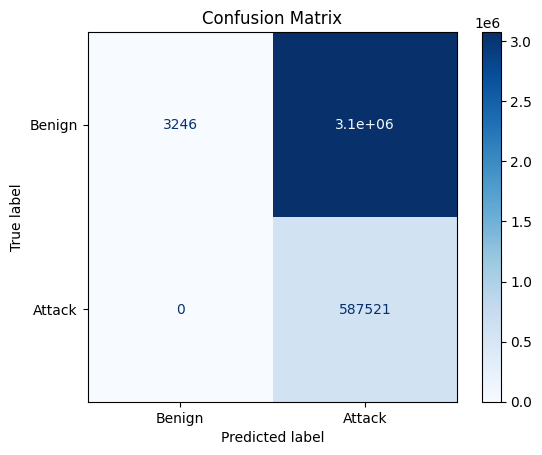


=== THRESHOLD 3.172413793103448e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



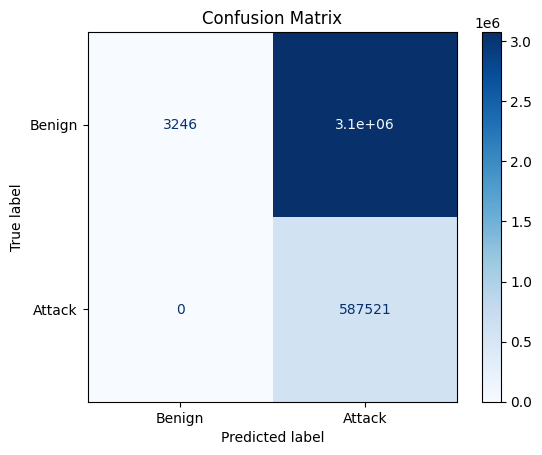


=== THRESHOLD 3.5137931034482755e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



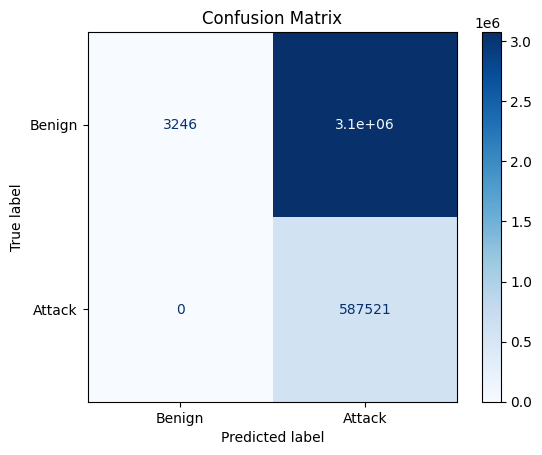


=== THRESHOLD 3.855172413793104e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1612
F1 Score: 0.2765
TPR: 1.0000
FPR: 0.9989
TNR: 0.0011
FNR: 0.0000

              precision    recall  f1-score   support

      Benign       1.00      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.58      0.50      0.14   3665771
weighted avg       0.87      0.16      0.05   3665771



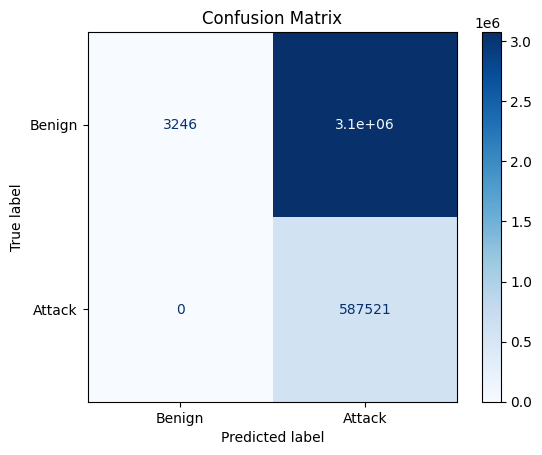


=== THRESHOLD 4.196551724137931e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1608
F1 Score: 0.2760
TPR: 0.9979
FPR: 0.9989
TNR: 0.0011
FNR: 0.0021

              precision    recall  f1-score   support

      Benign       0.72      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.44      0.50      0.14   3665771
weighted avg       0.63      0.16      0.05   3665771



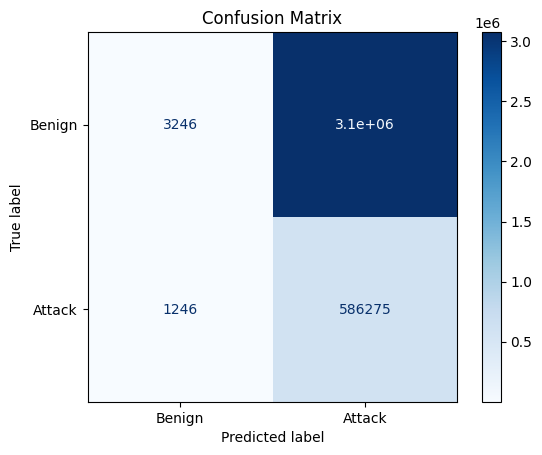


=== THRESHOLD 4.537931034482759e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1608
F1 Score: 0.2760
TPR: 0.9979
FPR: 0.9989
TNR: 0.0011
FNR: 0.0021

              precision    recall  f1-score   support

      Benign       0.72      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.44      0.50      0.14   3665771
weighted avg       0.63      0.16      0.05   3665771



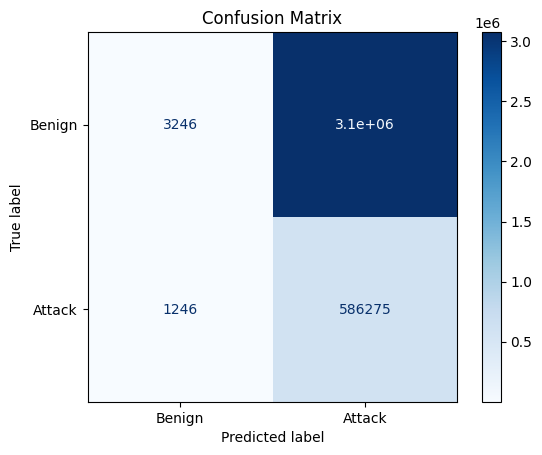


=== THRESHOLD 4.879310344827586e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1608
F1 Score: 0.2760
TPR: 0.9979
FPR: 0.9989
TNR: 0.0011
FNR: 0.0021

              precision    recall  f1-score   support

      Benign       0.72      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.44      0.50      0.14   3665771
weighted avg       0.63      0.16      0.05   3665771



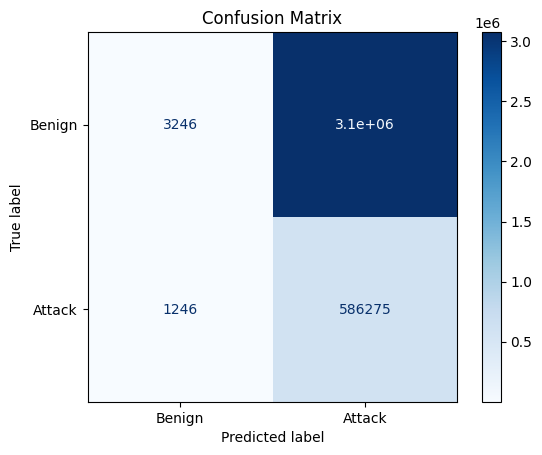


=== THRESHOLD 5.220689655172414e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1608
F1 Score: 0.2760
TPR: 0.9979
FPR: 0.9989
TNR: 0.0011
FNR: 0.0021

              precision    recall  f1-score   support

      Benign       0.72      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.44      0.50      0.14   3665771
weighted avg       0.63      0.16      0.05   3665771



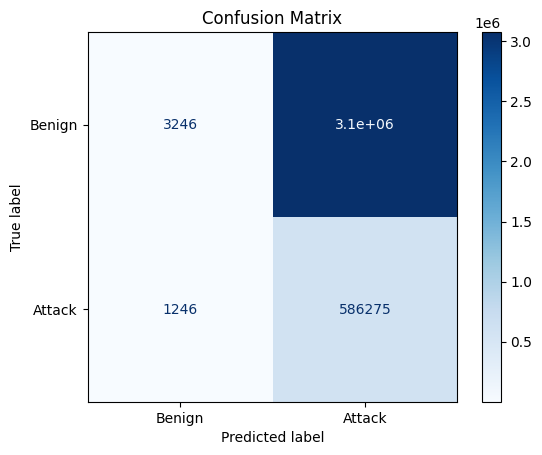


=== THRESHOLD 5.562068965517241e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1608
F1 Score: 0.2760
TPR: 0.9979
FPR: 0.9989
TNR: 0.0011
FNR: 0.0021

              precision    recall  f1-score   support

      Benign       0.72      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.44      0.50      0.14   3665771
weighted avg       0.63      0.16      0.05   3665771



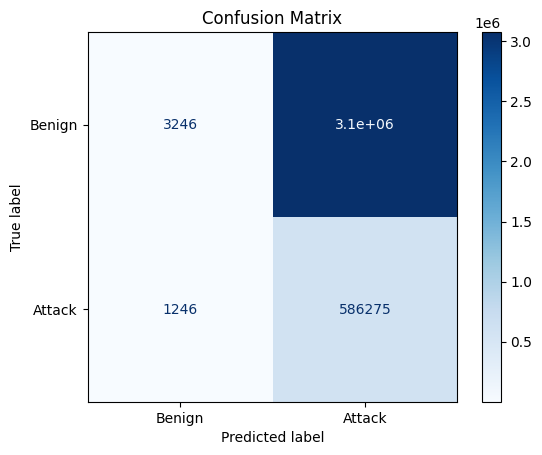


=== THRESHOLD 5.903448275862069e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



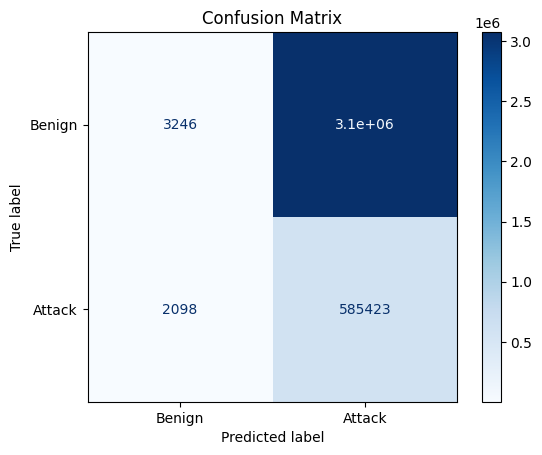


=== THRESHOLD 6.244827586206896e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



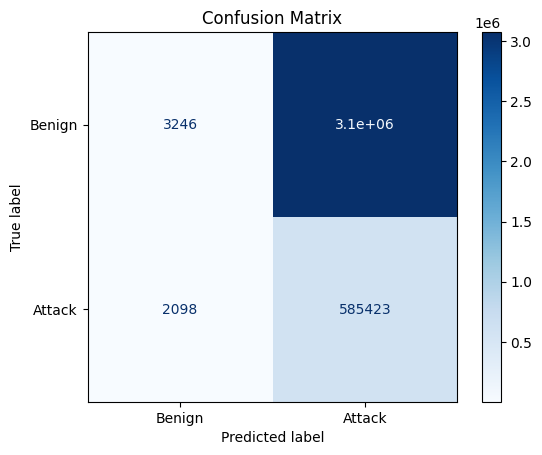


=== THRESHOLD 6.5862068965517236e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



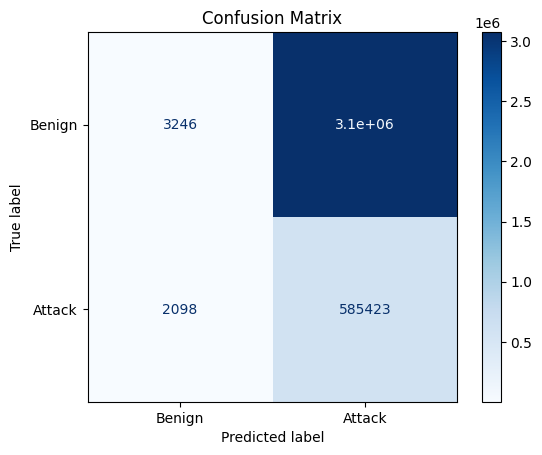


=== THRESHOLD 6.927586206896551e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



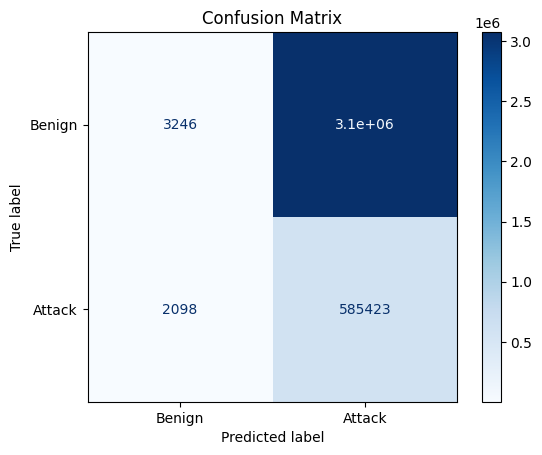


=== THRESHOLD 7.268965517241379e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



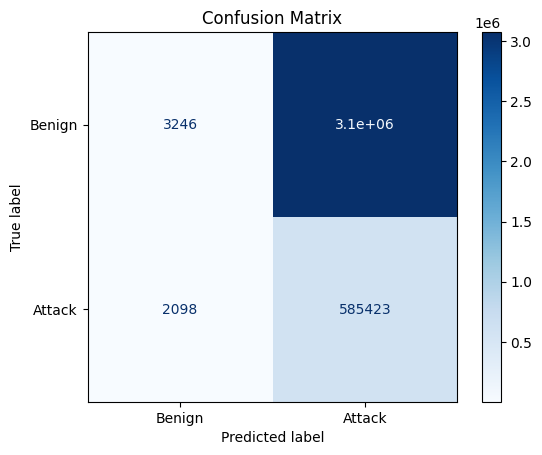


=== THRESHOLD 7.610344827586207e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



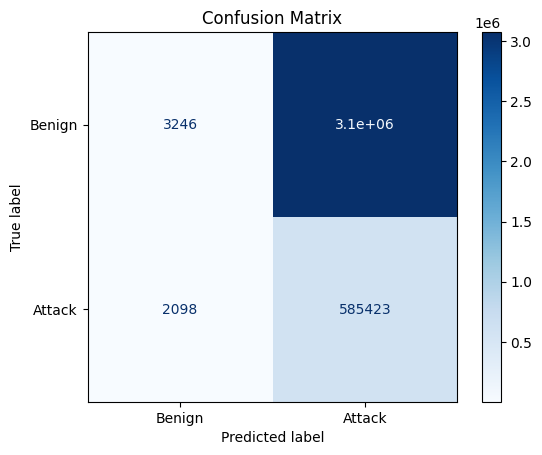


=== THRESHOLD 7.951724137931034e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



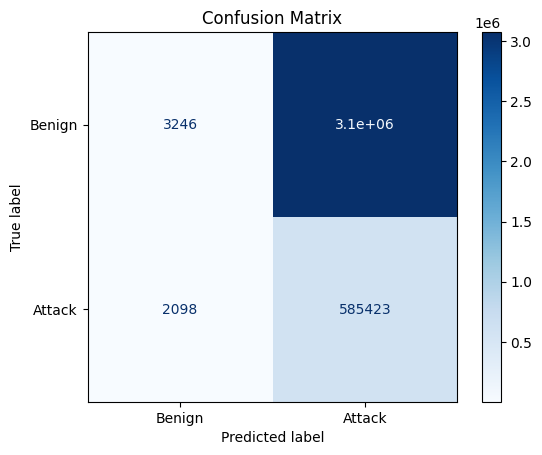


=== THRESHOLD 8.293103448275863e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



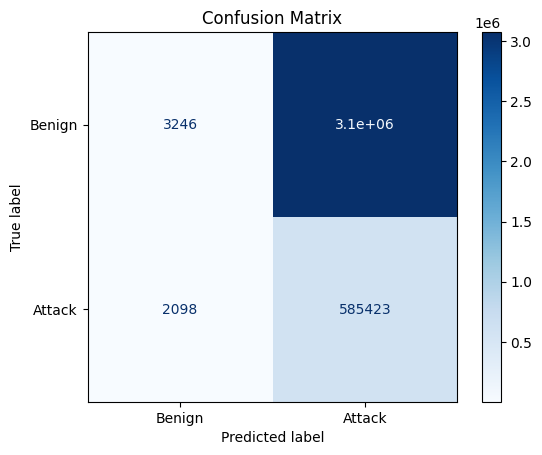


=== THRESHOLD 8.634482758620691e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1606
F1 Score: 0.2756
TPR: 0.9964
FPR: 0.9989
TNR: 0.0011
FNR: 0.0036

              precision    recall  f1-score   support

      Benign       0.61      0.00      0.00   3078250
      Attack       0.16      1.00      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.38      0.50      0.14   3665771
weighted avg       0.54      0.16      0.05   3665771



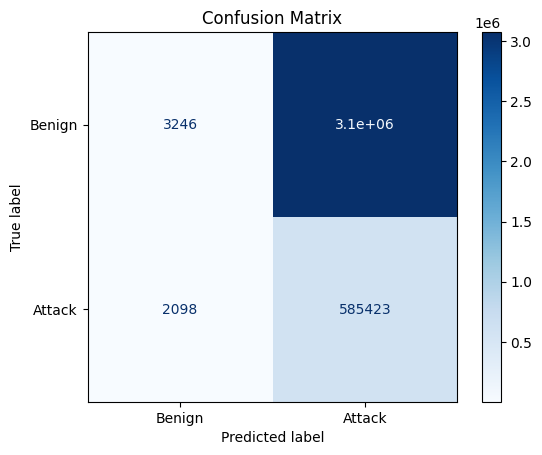


=== THRESHOLD 8.975862068965518e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1602
F1 Score: 0.2750
TPR: 0.9939
FPR: 0.9989
TNR: 0.0011
FNR: 0.0061

              precision    recall  f1-score   support

      Benign       0.47      0.00      0.00   3078250
      Attack       0.16      0.99      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.32      0.50      0.14   3665771
weighted avg       0.42      0.16      0.05   3665771



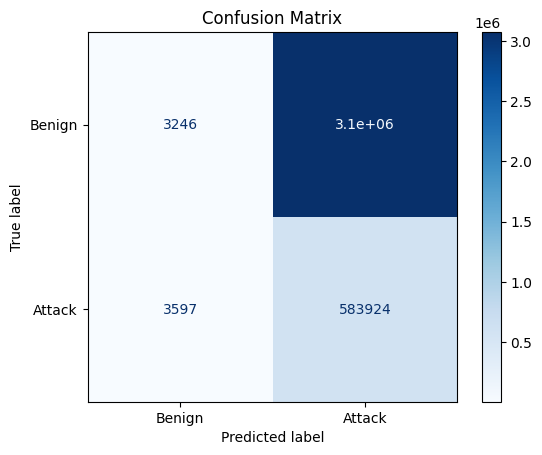


=== THRESHOLD 9.317241379310346e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1602
F1 Score: 0.2750
TPR: 0.9939
FPR: 0.9989
TNR: 0.0011
FNR: 0.0061

              precision    recall  f1-score   support

      Benign       0.47      0.00      0.00   3078250
      Attack       0.16      0.99      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.32      0.50      0.14   3665771
weighted avg       0.42      0.16      0.05   3665771



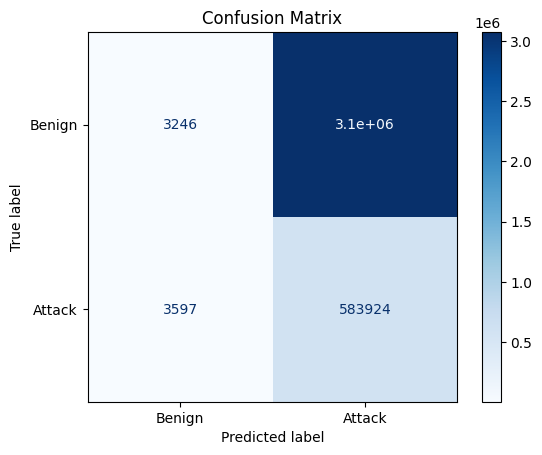


=== THRESHOLD 9.658620689655173e-06 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1602
F1 Score: 0.2750
TPR: 0.9939
FPR: 0.9989
TNR: 0.0011
FNR: 0.0061

              precision    recall  f1-score   support

      Benign       0.47      0.00      0.00   3078250
      Attack       0.16      0.99      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.32      0.50      0.14   3665771
weighted avg       0.42      0.16      0.05   3665771



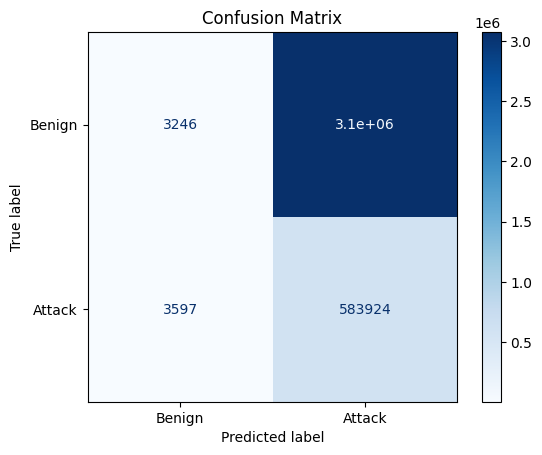


=== THRESHOLD 1e-05 ===
Initi anomaly column
Iterating through anomalies_df
Starting Evaluation
Accuracy: 0.1602
F1 Score: 0.2750
TPR: 0.9939
FPR: 0.9989
TNR: 0.0011
FNR: 0.0061

              precision    recall  f1-score   support

      Benign       0.47      0.00      0.00   3078250
      Attack       0.16      0.99      0.28    587521

    accuracy                           0.16   3665771
   macro avg       0.32      0.50      0.14   3665771
weighted avg       0.42      0.16      0.05   3665771



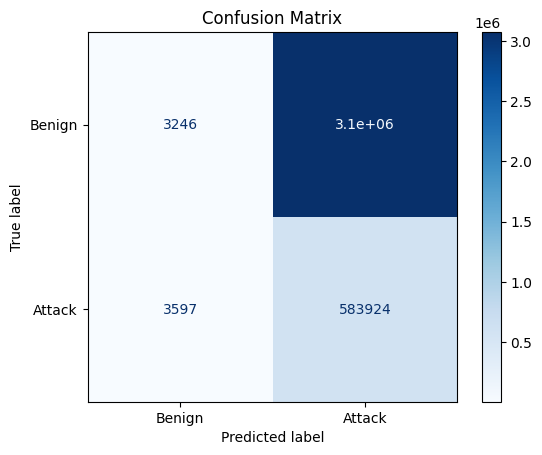

In [15]:
apply_thresholds_and_evaluate(mse_df, dos_data, thresholds)

In [ ]:
######
###OLD CODE BELOW
####

In [11]:
def arima_anomaly_detection(window, order=(0, 0, 0), mse_threshold=0.01):
    """
    Perform ARIMA-based anomaly detection on a window of CAN data.
    
    Args:
        window (pd.DataFrame): CAN data window with 'ID', 'Timestamp', and 'Periodicity' columns.
        order (tuple): ARIMA model order (p,d,q)
        mse_threshold (float or list): MSE threshold(s) for anomaly flagging.

    Returns:
        dict: Anomaly detection result {ID: MSE, ...}
        dict: Dictionary {threshold: list of anomalous IDs for each threshold}
    """
    mse_results = {}
    anomalies_by_threshold = {}

    # If threshold is a list, initialize anomaly lists for each
    if isinstance(mse_threshold, list):
        for thresh in mse_threshold:
            anomalies_by_threshold[thresh] = []
    else:
        anomalies_by_threshold[mse_threshold] = []

    # Loop through each unique ID
    for can_id in window['ID'].unique():
        id_data = window[window['ID'] == can_id]['Periodicity'].values

        # Need at least 3 points to fit ARIMA
        if len(id_data) >= 3:
            try:
                model = ARIMA(id_data, order=order)
                model_fit = model.fit()
                predictions = model_fit.predict()

                mse = mean_squared_error(id_data, predictions)
                mse_results[can_id] = mse

                # Compare against all thresholds
                for thresh in anomalies_by_threshold.keys():
                    if mse > thresh:
                        anomalies_by_threshold[thresh].append(can_id)

            except Exception as e:
                print(f"ARIMA failed for ID {can_id}: {e}")
                continue

    return mse_results, anomalies_by_threshold

In [13]:
for window in tqdm(windows, desc="Detecting anomalies"):
    mse_results, anomalies = arima_anomaly_detection(window, order=(0, 0, 0), mse_threshold=0.01)

    for anomaly_id in anomalies:
        mask = (normal_data['ID'] == anomaly_id) & (normal_data['Timestamp'].isin(window['Timestamp']))
        normal_data.loc[mask, 'Anomaly'] = 1


Detecting anomalies: 100%|██████████| 507/507 [02:40<00:00,  3.17it/s]


In [14]:
# Now normal_data has an 'Anomaly' column — 1 for detected anomaly, 0 otherwise
print(normal_data.head())

                      Timestamp    ID  DLC              Payload  label  \
0 2016-11-14 11:03:54.850202084   848    8   371692544708313250      0   
1 2016-11-14 11:03:54.850423098   704    8  1441151880758558720      0   
2 2016-11-14 11:03:54.850976944  1072    8                    0      0   
3 2016-11-14 11:03:54.851214886  1201    8                    0      0   
4 2016-11-14 11:03:54.851463079   497    8                    0      0   

   Anomaly  
0        0  
1        0  
2        0  
3        0  
4        0  


In [12]:
real_labels = normal_data['label']
predicted_labels = normal_data['Anomaly']

def evaluate(true_labels, predictions):

    TP = np.sum((predictions == 1) & (true_labels == 1))
    TN = np.sum((predictions == 0) & (true_labels == 0))
    FP = np.sum((predictions == 1) & (true_labels == 0))
    FN = np.sum((predictions == 0) & (true_labels == 1))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    TPR = recall  # True Positive Rate
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0  # False Positive Rate
    TNR = TN / (TN + FP) if (TN + FP) > 0 else 0  # True Negative Rate
    FNR = FN / (TP + FN) if (TP + FN) > 0 else 0  # False Negative Rate

    #Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1_score:.4f}")
    print(f"TPR: {TPR:.4f}")
    print(f"FPR: {FPR:.4f}")
    print(f"TNR: {TNR:.4f}")
    print(f"FNR: {FNR:.4f}")

    if len(set(list(true_labels))) == 2:

        print("")
        print(classification_report(true_labels, predictions, target_names=['Benign', 'Attack']))

        ##Plot confusion matrix with seaborn
        cm = confusion_matrix(true_labels, predictions)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Attack'])
        cm_display.plot(cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.show()
    else:
        pass

evaluate(real_labels, predicted_labels)

Accuracy: 1.0000
F1 Score: 0.0000
TPR: 0.0000
FPR: 0.0000
TNR: 1.0000
FNR: 0.0000


In [13]:
dos_data = read_ch_data(dos_data_path)
dos_data = transform_data(dos_data)

In [14]:
dos_data.head()

,Timestamp,ID,DLC,Payload,label,Anomaly
0,2016-11-03 18:39:36.389426947,790,8,369691032840896623,0,0
1,2016-11-03 18:39:36.389636040,399,8,18328243108518297600,0,0
2,2016-11-03 18:39:36.389863968,608,8,1810766114876976442,0,0
3,2016-11-03 18:39:36.390095949,672,8,7205928855671061760,0,0
4,2016-11-03 18:39:36.390332937,809,8,4664461563235663892,0,0


In [15]:
dos_windows = split_into_windows(dos_data, window_size=1)


=== THRESHOLD 0.001 ===


Detecting anomalies (threshold 0.001): 100%|██████████| 2811/2811 [31:23<00:00,  1.49it/s]


Accuracy: 0.7556
F1 Score: 0.0000
TPR: 0.0000
FPR: 0.1002
TNR: 0.8998
FNR: 1.0000

              precision    recall  f1-score   support

      Benign       0.83      0.90      0.86   3078250
      Attack       0.00      0.00      0.00    587521

    accuracy                           0.76   3665771
   macro avg       0.41      0.45      0.43   3665771
weighted avg       0.69      0.76      0.72   3665771



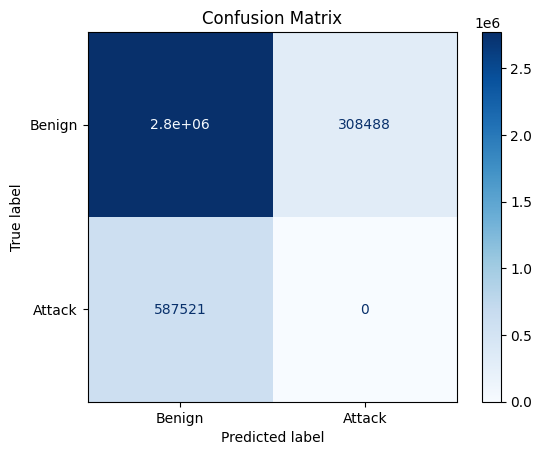


=== THRESHOLD 0.01 ===


Detecting anomalies (threshold 0.01): 100%|██████████| 2811/2811 [16:13<00:00,  2.89it/s]


Accuracy: 0.8313
F1 Score: 0.0000
TPR: 0.0000
FPR: 0.0100
TNR: 0.9900
FNR: 1.0000

              precision    recall  f1-score   support

      Benign       0.84      0.99      0.91   3078250
      Attack       0.00      0.00      0.00    587521

    accuracy                           0.83   3665771
   macro avg       0.42      0.49      0.45   3665771
weighted avg       0.70      0.83      0.76   3665771



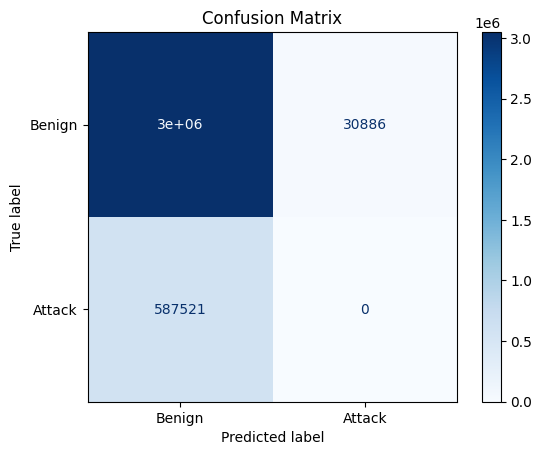


=== THRESHOLD 0.1 ===


Detecting anomalies (threshold 0.1): 100%|██████████| 2811/2811 [11:48<00:00,  3.97it/s]


Accuracy: 0.8397
F1 Score: 0.0000
TPR: 0.0000
FPR: 0.0001
TNR: 0.9999
FNR: 1.0000

              precision    recall  f1-score   support

      Benign       0.84      1.00      0.91   3078250
      Attack       0.00      0.00      0.00    587521

    accuracy                           0.84   3665771
   macro avg       0.42      0.50      0.46   3665771
weighted avg       0.71      0.84      0.77   3665771



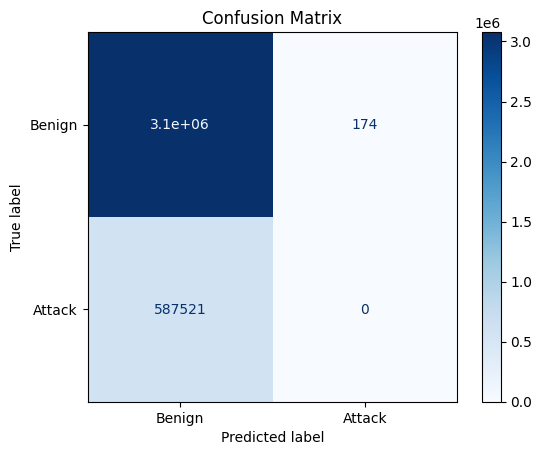


=== THRESHOLD 1 ===


Detecting anomalies (threshold 1): 100%|██████████| 2811/2811 [12:36<00:00,  3.72it/s]


Accuracy: 0.8397
F1 Score: 0.0000
TPR: 0.0000
FPR: 0.0000
TNR: 1.0000
FNR: 1.0000

              precision    recall  f1-score   support

      Benign       0.84      1.00      0.91   3078250
      Attack       0.00      0.00      0.00    587521

    accuracy                           0.84   3665771
   macro avg       0.42      0.50      0.46   3665771
weighted avg       0.71      0.84      0.77   3665771



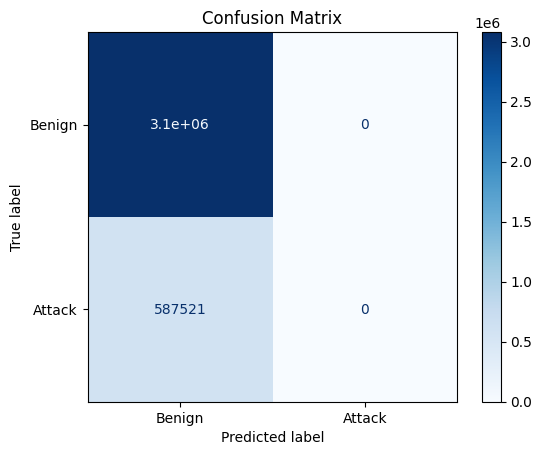


=== THRESHOLD 5 ===


Detecting anomalies (threshold 5): 100%|██████████| 2811/2811 [12:25<00:00,  3.77it/s]


Accuracy: 0.8397
F1 Score: 0.0000
TPR: 0.0000
FPR: 0.0000
TNR: 1.0000
FNR: 1.0000

              precision    recall  f1-score   support

      Benign       0.84      1.00      0.91   3078250
      Attack       0.00      0.00      0.00    587521

    accuracy                           0.84   3665771
   macro avg       0.42      0.50      0.46   3665771
weighted avg       0.71      0.84      0.77   3665771



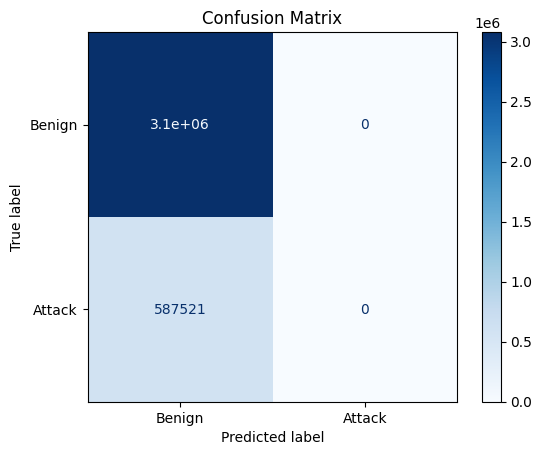


=== THRESHOLD 10 ===


Detecting anomalies (threshold 10): 100%|██████████| 2811/2811 [11:15<00:00,  4.16it/s]


Accuracy: 0.8397
F1 Score: 0.0000
TPR: 0.0000
FPR: 0.0000
TNR: 1.0000
FNR: 1.0000

              precision    recall  f1-score   support

      Benign       0.84      1.00      0.91   3078250
      Attack       0.00      0.00      0.00    587521

    accuracy                           0.84   3665771
   macro avg       0.42      0.50      0.46   3665771
weighted avg       0.71      0.84      0.77   3665771



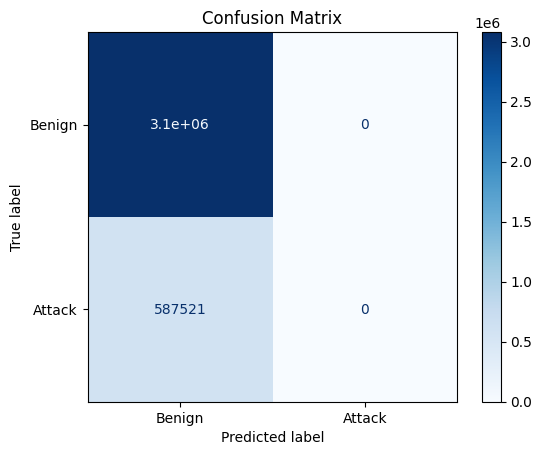

In [ ]:
# thresh = [0.001, 0.01, 0.1, 1, 5, 10]


# # for threshold in thresh:

# #     print(f"THRESHOLD {threshold}")

# #     for window in tqdm(dos_windows, desc="Detecting anomalies"):
# #         mse_results, anomalies = arima_anomaly_detection(window, order=(0,0,0), mse_threshold=threshold)

# #         # Mark these rows in the original dataframe
# #     dos_data.loc[anomalies, 'Anomaly'] = 1

# #     y_true = dos_data['label']
# #     y_preds = dos_data['Anomaly']

# #     evaluate(y_true, y_preds)



thresh = [0.001, 0.01, 0.1, 1, 5, 10]


for threshold in thresh:
    print(f"\n=== THRESHOLD {threshold} ===")

    # Reset Anomaly column for each threshold test
    dos_data['Anomaly'] = 0

    for window in tqdm(dos_windows, desc=f"Detecting anomalies (threshold {threshold})"):
        _, anomalies_by_thresh = arima_anomaly_detection(window, order=(0, 0, 0), mse_threshold=[threshold])

        # Get anomalies for this threshold
        anomalies = anomalies_by_thresh[threshold]

        # Mark these anomalies in the original dataframe based on both ID and Timestamp match
        for anomaly_id in anomalies:
            mask = (dos_data['ID'] == anomaly_id) & (dos_data['Timestamp'].isin(window['Timestamp']))
            dos_data.loc[mask, 'Anomaly'] = 1

    # Evaluate predictions for this threshold
    y_true = dos_data['label']
    y_preds = dos_data['Anomaly']

    evaluate(y_true, y_preds)


=== THRESHOLD 1e-06 ===


Detecting anomalies (threshold 1e-06): 100%|██████████| 2811/2811 [1:01:40<00:00,  1.32s/it]


Accuracy: 0.2182
F1 Score: 0.2880
TPR: 0.9868
FPR: 0.9285
TNR: 0.0715
FNR: 0.0132

              precision    recall  f1-score   support

      Benign       0.97      0.07      0.13   3078250
      Attack       0.17      0.99      0.29    587521

    accuracy                           0.22   3665771
   macro avg       0.57      0.53      0.21   3665771
weighted avg       0.84      0.22      0.16   3665771



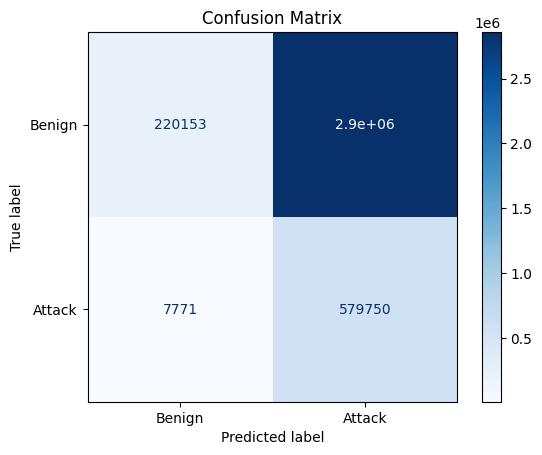


=== THRESHOLD 1e-05 ===


Detecting anomalies (threshold 1e-05): 100%|██████████| 2811/2811 [48:15<00:00,  1.03s/it]  


Accuracy: 0.6326
F1 Score: 0.3185
TPR: 0.5356
FPR: 0.3488
TNR: 0.6512
FNR: 0.4644

              precision    recall  f1-score   support

      Benign       0.88      0.65      0.75   3078250
      Attack       0.23      0.54      0.32    587521

    accuracy                           0.63   3665771
   macro avg       0.55      0.59      0.53   3665771
weighted avg       0.78      0.63      0.68   3665771



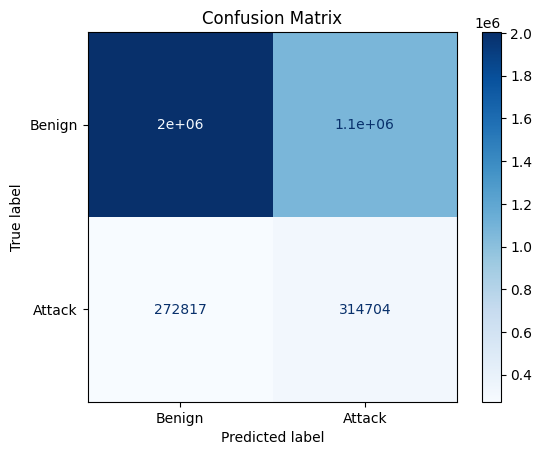


=== THRESHOLD 0.0001 ===


Detecting anomalies (threshold 0.0001): 100%|██████████| 2811/2811 [51:57<00:00,  1.11s/it]  


Accuracy: 0.6229
F1 Score: 0.0009
TPR: 0.0011
FPR: 0.2585
TNR: 0.7415
FNR: 0.9989

              precision    recall  f1-score   support

      Benign       0.80      0.74      0.77   3078250
      Attack       0.00      0.00      0.00    587521

    accuracy                           0.62   3665771
   macro avg       0.40      0.37      0.38   3665771
weighted avg       0.67      0.62      0.64   3665771



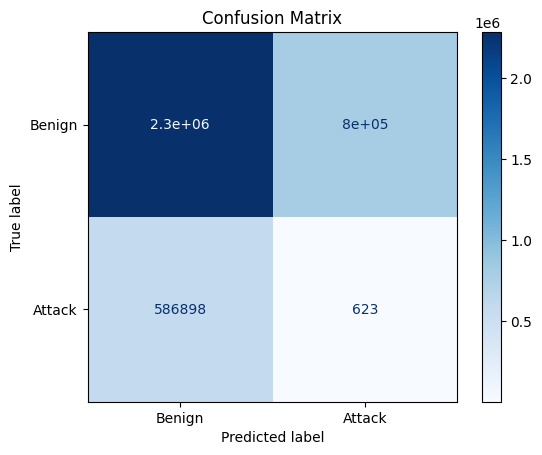


=== THRESHOLD 0.001 ===


Detecting anomalies (threshold 0.001): 100%|██████████| 2811/2811 [29:38<00:00,  1.58it/s]


Accuracy: 0.7556
F1 Score: 0.0000
TPR: 0.0000
FPR: 0.1002
TNR: 0.8998
FNR: 1.0000

              precision    recall  f1-score   support

      Benign       0.83      0.90      0.86   3078250
      Attack       0.00      0.00      0.00    587521

    accuracy                           0.76   3665771
   macro avg       0.41      0.45      0.43   3665771
weighted avg       0.69      0.76      0.72   3665771



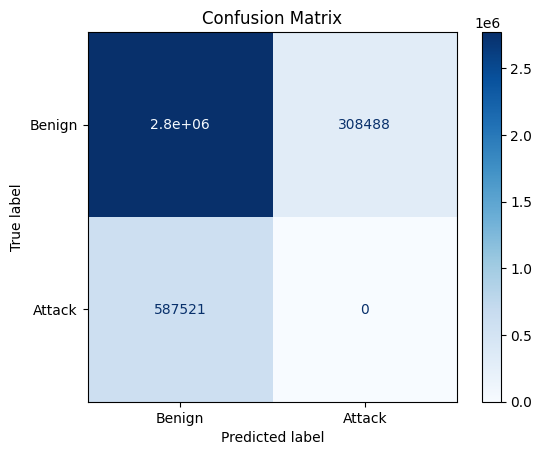

In [19]:

thresh = [0.000001, 0.00001, 0.0001, 0.001]


for threshold in thresh:
    print(f"\n=== THRESHOLD {threshold} ===")

    # Reset Anomaly column for each threshold test
    dos_data['Anomaly'] = 0

    for window in tqdm(dos_windows, desc=f"Detecting anomalies (threshold {threshold})"):
        _, anomalies_by_thresh = arima_anomaly_detection(window, order=(0, 0, 0), mse_threshold=[threshold])

        # Get anomalies for this threshold
        anomalies = anomalies_by_thresh[threshold]

        # Mark these anomalies in the original dataframe based on both ID and Timestamp match
        for anomaly_id in anomalies:
            mask = (dos_data['ID'] == anomaly_id) & (dos_data['Timestamp'].isin(window['Timestamp']))
            dos_data.loc[mask, 'Anomaly'] = 1

    # Evaluate predictions for this threshold
    y_true = dos_data['label']
    y_preds = dos_data['Anomaly']

    evaluate(y_true, y_preds)

In [ ]:
# from tqdm import tqdm
# from collections import Counter

# # To store selected orders
# selected_orders = []

# # Total number of windows
# total_windows = len(normal_windows)
# threshold_index = int(0.2 * total_windows)
# sample_windows = normal_windows[0:threshold_index]


# for i, window in enumerate(tqdm(sample_windows, desc="Processing Windows")):
#     anomalies = []
#     mse_results = {}

#     for can_id in window['ID'].unique():
#         id_data = window[window['ID'] == can_id]['Periodicity'].values

#         if len(id_data) >= 3:
#             try:
#                 model = auto_arima(id_data,
#                                    start_p=0, start_q=0,
#                                    max_p=3, max_q=3,
#                                    d=None,
#                                    seasonal=False,
#                                    stepwise=True,
#                                    suppress_warnings=True,
#                                    trace=False,
#                                    error_action='ignore')

#                 predictions = model.predict_in_sample()
#                 mse = mean_squared_error(id_data, predictions)
#                 mse_results[can_id] = mse

#                 # Save the order being selected
#                 selected_orders.append(model.order)

#                 if mse > 0.02:
#                     anomalies.append(can_id)

#             except Exception as e:
#                 print(f"Auto ARIMA failed for ID {can_id}: {e}")
#                 continue

#     if len(anomalies) > 0:
#         print(f"Window {i+1}: Anomalies Detected in IDs: {anomalies}")

#     # After 20% windows — print most common order
#     if i+1 == threshold_index:
#         most_common_order = Counter(selected_orders).most_common(1)[0][0]
#         print(f"\nMost common ARIMA order after {threshold_index} windows: {most_common_order}\n")
#         break  # You can remove this break if you want to keep processing more windows



In [22]:

thresh = np.linspace(0.0000001, 0.00001, num=20)


for threshold in thresh:
    print(f"\n=== THRESHOLD {threshold} ===")

    # Reset Anomaly column for each threshold test
    dos_data['Anomaly'] = 0

    for window in tqdm(dos_windows, desc=f"Detecting anomalies (threshold {threshold})"):

        # Get anomalies for this threshold
        anomalies = anomalies_by_thresh[threshold]

        # Mark these anomalies in the original dataframe based on both ID and Timestamp match
        for anomaly_id in anomalies:
            mask = (dos_data['ID'] == anomaly_id) & (dos_data['Timestamp'].isin(window['Timestamp']))
            dos_data.loc[mask, 'Anomaly'] = 1

    # Evaluate predictions for this threshold
    y_true = dos_data['label']
    y_preds = dos_data['Anomaly']

    evaluate(y_true, y_preds)


=== THRESHOLD 1e-07 ===


Detecting anomalies (threshold 1e-07):   0%|          | 0/2811 [00:00<?, ?it/s]


KeyError: 1e-07